In [210]:
from pyod.models.copod import COPOD
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pyod
import pyod.models.auto_encoder_torch as ae
import pyod.models.cblof as cblof
import pyod.models.knn as knn
from sklearn.preprocessing import StandardScaler
import stumpy
from statsmodels.tsa.ar_model import AutoReg

In [211]:
def plot_results(data, anamoly_score, threshold, anamoly_pos, title, file_to_load):
    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(title)
    ax1.plot(total[0:threshold], color = 'gray')
    ax1.plot(total[threshold:], color = 'blue')
    ax1.set_ylabel('Value')
    ax1.axvline(threshold, label='threshold', color = 'black')
    ax1.axvline(anamoly_pos, label='predicted anamoly', color = 'red')
    ax2.plot(anamoly_score[0:threshold], color = 'gray')
    ax2.plot(anamoly_score[threshold:], color = 'blue')
    ax2.set_ylabel('Anamoly Score')
    ax2.axvline(threshold, label='threshold', color = 'black')
    ax2.axvline(anamoly_pos, label='predicted anamoly', color = 'red')
    plt.show()

In [223]:
# Define split data

def split_data(file_path, index):
    file_name = os.listdir(file_path)[index]
    test_data_start_pt = int(re.findall(
        r'[0-9]*.txt', file_name)[0].split('.')[0])
    
    total_data = pd.read_csv(os.path.join(file_path, os.listdir(file_path)[index]))
    
    # Handle data formatting issue
    if total_data.shape[1] == 1:
        total_data = np.genfromtxt(os.path.join(file_path, os.listdir(file_path)[index]))
        total_data = pd.DataFrame(total_data)
    
    train_data = total_data[0:test_data_start_pt]
    test_data = total_data[test_data_start_pt+1:len(total_data)]
    #scaler = StandardScaler()
    #scaler.fit(train_data)
    #train_scaled = scaler.transform(train_data)
    #test_scaled = scaler.transform(test_data)
    return train_data, test_data, total_data, test_data_start_pt

In [213]:
def calculate_prominence_without_smoothing(anomaly_scores):
    #In this case we define anomaly score as simply the division between the highest anomaly score and the second highest
    highest_anomaly_score = sorted(zip(range(anomaly_scores.shape[0]),anomaly_scores), key = lambda x : x[1], reverse = True)[0][1]
    second_highest_anomaly_score = sorted(zip(range(anomaly_scores.shape[0]),anomaly_scores), key = lambda x : x[1], reverse = True)[1][1]
    return highest_anomaly_score/second_highest_anomaly_score

In [214]:
#reduces the noise of anomaly detection and increases the stability of anomaly detection
def smoothing(anomaly_data,m):
    start_point = m
    end_point_for_smoothing = anomaly_data.shape[0] - 1
    smoothed_anomaly_scores = np.zeros(shape = (anomaly_data.shape[0]))
    for i in range(start_point,end_point_for_smoothing):
        #smoothed_anomaly_scores[i] = np.mean(anomaly_data[i - m:i+1])
        smoothed_anomaly_scores[i] = np.mean(anomaly_data[i - m:i + 1])
    return smoothed_anomaly_scores

#prominence is defined as the ratio of the first peak in time range 0 to Tmax 
#and the second peak in the time ranges 0 to t1 - m and t1 + m to Tmax (t1 is position of first peak)
def calculate_prominence(anomaly_scores,m):
    anomaly_scores = tuple(zip(range(anomaly_scores.shape[0]),anomaly_scores))
    #finding first highest anomaly score in the range 0 to Tmax
    highest_score = sorted(anomaly_scores,key = lambda x:x[1],reverse=True)[0]
    #time at which this score is found is t1
    highest_score
    #finding second highest score from the ranges 0 to t1  - m
    try:
        second_score_1 = sorted(anomaly_scores[:highest_score[0] - m],key = lambda x:x[1],reverse=True)[0]
    except:
        second_score_1 = sorted(anomaly_scores[:highest_score[0]],key = lambda x:x[1],reverse=True)[0]
    try:
        second_score_2 = sorted(anomaly_scores[highest_score[0] + m:],key = lambda x:x[1],reverse=True)[0]
    except:
        second_score_2 = sorted(anomaly_scores[highest_score[0]:],key = lambda x:x[1],reverse=True)[0]
    second_highest_score = max(second_score_1,second_score_2,key=lambda x:x[1])
    prominence = highest_score[1]/second_highest_score[1]
    #after prominence is calculate, the point of outlier is selected as the time of the first peak location 
    #(time at which higest score occurs)
    return prominence

In [215]:
def train_models(train,test,threshold):
    
    # Autoencoder
    anamoly_pos_autoenc, test_outlier_scores_autoenc, prominence_score_autoenc = Detect_AE()
    
    # Cluster-based Local Outlier Factor
    anamoly_pos_CBLOF, test_outlier_scores_CBLOF, prominence_score_CBLOF = Detect_CBLOF()

    # K-Nearest Neighbors
    anamoly_pos_KNN, test_outlier_scores_KNN, prominence_score_KNN = Detect_KNN()

    # Copula-Based Outlier Detection
    anamoly_pos_COPOD, test_outlier_scores_COPOD, prominence_score_COPOD = Detect_COPOD()

    # Matrix Profile Algorithm

    anamoly_pos_MP, test_outlier_scores_MP, prominence_score_MP = Detect_MatrixProfile(train,test,threshold)

    # AutoRegressive Algorithm 

    anamoly_pos_AR, test_outlier_scores_AR, prominence_score_AR = Detect_AutoRegression(train,test,threshold)

    
    return anamoly_pos_autoenc, anamoly_pos_CBLOF, anamoly_pos_KNN, anamoly_pos_COPOD,anamoly_pos_MP,anamoly_pos_AR, \
           prominence_score_autoenc, prominence_score_CBLOF, prominence_score_KNN, prominence_score_COPOD, prominence_score_MP, prominence_score_AR
    

In [225]:
def Detect_AE():
    # Implement algorithm #1 (Autoencoding)
    # https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod-models-auto-encoder-module

    # Define model (TBD hidden neuron details...)
    clf = ae.AutoEncoder(epochs = 2, batch_norm = False)

    # train = np.array(train).reshape(-1,1)
    # test = np.array(test).reshape(-1,1)
    # scaler = StandardScaler()
    # scaler.fit(train)
    # total = np.concatenate((train,test))
    # #train = scaler.transform(train)
    # total = scaler.transform(total)
    # Fit model
    clf.fit(train)
    
    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_
    
    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted Anamoloy from Autoencoder algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [217]:
def Detect_CBLOF():
    # Implement algorithm #2 (CBLOF)
    outliers_fraction = 0.000000001

    # Define model (TBD hidden neuron details...)
    clf = cblof.CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)

    # train = np.array(train).reshape(-1,1)
    # test = np.array(test).reshape(-1,1)
    # scaler = StandardScaler()
    # scaler.fit(train)
    # total = np.concatenate((train,test))
    # #train = scaler.transform(train)
    # total = scaler.transform(total)
    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted Anamoloy from CBLOF algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [218]:
def Detect_KNN():
    # Implement algorithm #3 (K-Nearest Neighbors)
    outliers_fraction = 0.000000001

    # Define model (TBD hidden neuron details...)
    clf = knn.KNN(contamination=outliers_fraction)
    
    # train = np.array(train).reshape(-1,1)
    # test = np.array(test).reshape(-1,1)
    # scaler = StandardScaler()
    # scaler.fit(train)
    # total = np.concatenate((train,test))
    # #train = scaler.transform(train)
    # total = scaler.transform(total)
    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted anamoloy from KNN algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [219]:
def Detect_COPOD():    
    # Implement algorithm #4 (COPOD)

    ##### COPOD Algorithm
    clf = COPOD()
    clf.fit(train)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted anamoloy from COPOD algorithm  is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [220]:
def Detect_MatrixProfile(train,test,threshold):
    #Implement the Matrix Profile Algorithm with a A-B join
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)

    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    #window size
    m = 100

    mp = stumpy.stump(test.reshape(test.shape[0],),m,train.reshape(train.shape[0],),ignore_trivial=False,normalize=False)

    anomaly_scores = pd.Series(mp[:,0])
    #finding outlier without smoothing
    outlier_position = np.argsort(mp[:,0])[-1]
    print("Predicted anamoloy from MP algorithm  is located at location: " + str(outlier_position + threshold))
    #unsmoothed prominence score
    #prominence_score_matrix_profile = calculate_prominence_without_smoothing(mp[:,0])
    smoothed_anomaly_scores = smoothing(anomaly_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)


    return outlier_position + threshold, anomaly_scores, prominence_score

In [221]:
def Detect_AutoRegression(train,test,threshold):
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)

    # scaler = StandardScaler()
    # scaler.fit(train)
    # train_scaled = scaler.transform(train)
    # test_scaled = scaler.transform(test)

    train_scaled = train
    test_scaled = test
    
    window = 100
    model = AutoReg(train_scaled,lags = window)
    model_fit = model.fit()
    coef = model_fit.params
    #to make the first m predictions in the test data, we need the last 100 data from train dataset
    history = train_scaled[len(train_scaled) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    residual_err = list()

    for t in range(len(test_scaled)):
        length = len(history)
        #finding the past 100 points to predict the next point as prediction requires
        #applying coef from model_fit.params to the lag values
        lag = [history[i] for i in range(length - window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window - d - 1]
        new_history = test_scaled[t]
        predictions.append(yhat)
        history.append(new_history)
        residual_err.append(np.abs(new_history-yhat)[0])
    #smoothed_anomaly_scores = smoothing(np.array(residual_err),m)
    #prominence,outlier_position = calculate_prominence(smoothed_anomaly_scores,m)
    #calculate outlier position without smoothing

    
    outlier_position = np.argsort(np.array(residual_err))[-1]
    #prominence = calculate_prominence_without_smoothing(np.array(residual_err))
    smoothed_anomaly_scores = smoothing(np.array(residual_err),100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    outlier_position = outlier_position + threshold
    print("Predicted anamoloy from AR algorithm  is located at location: " + str(outlier_position))
    anomaly_positions_without_smoothing = tuple(zip(range(len(residual_err)),residual_err))
    scores = sorted(anomaly_positions_without_smoothing, key = lambda x:x[1],reverse=True)
    first_outlier_position = scores[0][0] + threshold
    return first_outlier_position, pd.Series(np.array(residual_err)),prominence_score

In [232]:
### Initialize all anamoly lists to be zero

# Filename
file_name_list = []

# Autoencoder
anamoly_pos_autoenc = []
anamoly_prom_autoenc = []

# Cluster-based Local Outlier Factor
anamoly_pos_CBLOF = []
anamoly_prom_CBLOF = []

# K-Nearest Neighbors
anamoly_pos_KNN = []
anamoly_prom_KNN = []

# Copula-Based Outlier Detection
anamoly_pos_COPOD = []
anamoly_prom_COPOD = []

# Matrix Profile
anamoly_pos_MP = []
anamoly_prom_MP = []

# Autoregressive Model
anamoly_pos_AR = []
anamoly_prom_AR = []

# Ensemble prediction
predicted_voting = []
predicted_prom = []

# for k in range(len(os.listdir(file_path))-1):

# loop through all 250 files
for k in range(250):

    # define path to data directory
    file_path = os.path.join(os.getcwd(), 'KDD-Cup', 'data')
    file_name = os.listdir(file_path)[k+1]
    file_to_load = os.path.join(file_path, file_name)
    train, test, total, threshold = split_data(file_path, k+1)
    
    print("Analysis started for file " + file_name)
    
    autoenc_pred, CBLOF_pred, KNN_pred, COPOD_pred,MP_pred,AR_pred, autoenc_prom, CBLOF_prom, KNN_prom, COPOD_prom,MP_prom,AR_prom = train_models(train,test,threshold)
    
    # Add value for each item to list
    file_name_list.append(file_name) 
    anamoly_pos_autoenc.append(autoenc_pred) 
    anamoly_pos_CBLOF.append(CBLOF_pred) 
    anamoly_pos_KNN.append(KNN_pred) 
    anamoly_pos_COPOD.append(COPOD_pred)
    anamoly_pos_MP.append(MP_pred) 
    anamoly_pos_AR.append(AR_pred)
    anamoly_prom_autoenc.append(autoenc_prom) 
    anamoly_prom_CBLOF.append(CBLOF_prom) 
    anamoly_prom_KNN.append(KNN_prom) 
    anamoly_prom_COPOD.append(COPOD_prom)
    anamoly_prom_MP.append(MP_prom)
    anamoly_prom_AR.append(AR_prom)

    # Initially add zero to the list (voting mechanism handled within data frame below)
    predicted_voting.append(0)
    predicted_prom.append(0)
    
    
# Create Data frame of predicted anamolies
predictions = pd.DataFrame({'File Name': file_name_list, 'AutoEncoder': anamoly_pos_autoenc, 'CBLOF':anamoly_pos_CBLOF, 'KNN': anamoly_pos_KNN,'COPOD':anamoly_pos_COPOD,'MP':anamoly_pos_MP,'AR':anamoly_pos_AR, 'AutoEncoder_prom': anamoly_prom_autoenc, 'CBLOF_prom':anamoly_prom_CBLOF, 'KNN_prom': anamoly_prom_KNN, 'COPOD_prom':anamoly_prom_COPOD,'MP_prom':anamoly_prom_MP,'AR_prom':anamoly_prom_AR, 'Predicted_voting': predicted_voting, 'Predicted_prom':predicted_prom} ) 

# Prominence-based voting
predictions['Predicted_prom'] = np.select(
    [
        predictions['AutoEncoder_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['CBLOF_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['KNN_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['COPOD_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['MP_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['AR_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
    ], 
    [
        predictions['AutoEncoder'],
        predictions['CBLOF'],
        predictions['KNN'],
        predictions['COPOD'],
        predictions['MP'],
        predictions['AR'],
    ], 
    default=-9999
)

# Mode-based voting
predictions['Predicted_voting'] = predictions[['AutoEncoder', 'CBLOF', 'KNN', 'COPOD','MP','AR']].mode(axis=1, dropna=False)[0]

# Display data frame
predictions

# Creation of final prediction file
submission_file = pd.DataFrame()
submission_file['No.'] = predictions['File Name'].str[:3].astype('int32')
submission_file['Location of Anomaly'] = predictions['Predicted_prom']
submission_file.style.hide_index()

submission_file.to_csv(r'C:\Users\Paul\GitHub\Anomaly-Detection-Project\all_rerun.csv')

Analysis started for file 001_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 12.841979910321601 
epoch 1: training loss 12.188722244863973 
Predicted Anamoloy from Autoencoder algorithm is located at location: 66889
Predicted Anamoloy from CBLOF algorithm is located at location: 66889
Predicted anamoloy from KNN algorithm is located at location: 71185
Predicted anamoloy from COPOD algorithm  is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61488
Analysis started for file 002_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 14.248838019926762 
epoch 1: training loss 13.021266093419719 
Predicted Anamoloy from Autoencoder algorithm is located at location: 67096
Predicted Anamoloy from CBLOF algorithm is located at location: 67096
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61919
Analysis started for file 003_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 13.75939510029892 
epoch 1: training loss 12.519242465986412 
Predicted Anamoloy from Autoencoder algorithm is located at location: 71390
Predicted Anamoloy from CBLOF algorithm is located at location: 71390
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 46706
Analysis started for file 004_UCR_Anomaly_2500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 14.372086057180091 
epoch 1: training loss 9.98755494514598 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5591
Predicted Anamoloy from CBLOF algorithm is located at location: 5591
Predicted anamoloy from KNN algorithm is located at location: 559

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5578
Analysis started for file 005_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06021942664682865 
epoch 1: training loss 0.04308317806571722 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5390
Analysis started for file 006_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.05378681939840317 
epoch 1: training loss 0.03837134812772274 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5102
Predicted Anamoloy from CBLOF algorithm is located at location: 5102
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5951
Analysis started for file 007_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.056443062230944634 
epoch 1: training loss 0.040372352518141266 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5079
Predicted Anamoloy from CBLOF algorithm is located at location: 5079
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6518
Analysis started for file 008_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.05867520061135292 
epoch 1: training loss 0.03941927042603493 
Predicted Anamoloy from Autoencoder algorithm is located at location: 4792
Predicted Anamoloy from CBLOF algorithm is located at location: 4792
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5560
Analysis started for file 009_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.051454159043729304 
epoch 1: training loss 0.039918439604341986 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4850
Analysis started for file 010_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.05693112111091614 
epoch 1: training loss 0.03784878073632717 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5102
Predicted Anamoloy from CBLOF algorithm is located at location: 5102
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6053
Analysis started for file 011_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 144.65502247642786 
epoch 1: training loss 118.87581560634577 
Predicted Anamoloy from Autoencoder algorithm is located at location: 11863
Predicted Anamoloy from CBLOF algorithm is located at location: 25822
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 11863
Analysis started for file 012_UCR_Anomaly_15000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 244.39936921438937 
epoch 1: training loss 208.49577656381928 
Predicted Anamoloy from Autoencoder algorithm is located at location: 16055
Predicted Anamoloy from CBLOF algorithm is located at location: 22831
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 16055
Analysis started for file 013_UCR_Anomaly_15000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 486.5016747293696 
epoch 1: training loss 420.87126698117777 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 014_UCR_Anomaly_8000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 2021.2715800476074 
epoch 1: training loss 1386.4612778015137 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 015_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.2683911635332805 
epoch 1: training loss 0.918495979373622 
Predicted Anamoloy from Autoencoder algorithm is located at location: 47407
Predicted Anamoloy from CBLOF algorithm is located at location: 47407
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17099
Analysis started for file 016_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 783.7960998313442 
epoch 1: training loss 618.3215417193759 
Predicted Anamoloy from Autoencoder algorithm is located at location: 17027
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location: 1

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 017_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 572.0375531797956 
epoch 1: training loss 393.9613945347488 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6955
Predicted Anamoloy from CBLOF algorithm is located at location: 6955
Predicted anamoloy from KNN algorithm is located at location: 170

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8451
Analysis started for file 018_UCR_Anomaly_8000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 225.53273414230347 
epoch 1: training loss 245.11592619895936 
Predicted Anamoloy from Autoencoder algorithm is located at location: 23850
Predicted Anamoloy from CBLOF algorithm is located at location: 23850
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8451
Analysis started for file 019_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07861408800076528 
epoch 1: training loss 0.053143357875857763 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10505
Predicted Anamoloy from CBLOF algorithm is located at location: 8083
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 7798
Analysis started for file 020_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07463409485900478 
epoch 1: training loss 0.057139127177132924 
Predicted Anamoloy from Autoencoder algorithm is located at location: 9407
Predicted Anamoloy from CBLOF algorithm is located at location: 9407
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 11415
Analysis started for file 021_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07983292331978394 
epoch 1: training loss 0.05282007389743427 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10504
Predicted Anamoloy from CBLOF algorithm is located at location: 8743
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5992
Analysis started for file 022_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07835138437151909 
epoch 1: training loss 0.055647360563278195 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10941
Predicted Anamoloy from CBLOF algorithm is located at location: 10941
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4000
Analysis started for file 023_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0783152166920103 
epoch 1: training loss 0.05379904813732311 
Predicted Anamoloy from Autoencoder algorithm is located at location: 9629
Predicted Anamoloy from CBLOF algorithm is located at location: 6359
Predicted anamoloy from KNN algorithm is located at location: 1

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8715
Analysis started for file 024_UCR_Anomaly_3200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.010636447325814515 
epoch 1: training loss 0.005760611183941364 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7438
Predicted Anamoloy from CBLOF algorithm is located at location: 7438
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4525
Analysis started for file 025_UCR_Anomaly_2800.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.015225930620958521 
epoch 1: training loss 0.007303107011301274 
Predicted Anamoloy from Autoencoder algorithm is located at location: 3539
Predicted Anamoloy from CBLOF algorithm is located at location: 6359
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5606
Analysis started for file 026_UCR_Anomaly_1700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.025392574180538457 
epoch 1: training loss 0.01326901695035674 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7201
Predicted Anamoloy from CBLOF algorithm is located at location: 7201
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 7527
Analysis started for file 027_UCR_Anomaly_1200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.022914832114781205 
epoch 1: training loss 0.014933594772102017 
Predicted Anamoloy from Autoencoder algorithm is located at location: 3064
Predicted Anamoloy from CBLOF algorithm is located at location: 3064
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4197
Analysis started for file 028_UCR_Anomaly_1600.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.03463736241683364 
epoch 1: training loss 0.015387622974812984 
Predicted Anamoloy from Autoencoder algorithm is located at location: 4163
Predicted Anamoloy from CBLOF algorithm is located at location: 4163
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 3257
Analysis started for file 029_UCR_Anomaly_2300.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.020864632207020704 
epoch 1: training loss 0.011705298817509579 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7270
Predicted Anamoloy from CBLOF algorithm is located at location: 7270
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4541
Analysis started for file 030_UCR_Anomaly_3000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02029040031769174 
epoch 1: training loss 0.01123404876388451 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5078
Predicted Anamoloy from CBLOF algorithm is located at location: 5078
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4186
Analysis started for file 031_UCR_Anomaly_2700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02167693657033584 
epoch 1: training loss 0.011423508455867277 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7456
Predicted Anamoloy from CBLOF algorithm is located at location: 7456
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5860
Analysis started for file 032_UCR_Anomaly_1000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.028417634675861336 
epoch 1: training loss 0.014839061157545075 
Predicted Anamoloy from Autoencoder algorithm is located at location: 3822
Predicted Anamoloy from CBLOF algorithm is located at location: 3822
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4842
Analysis started for file 033_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.021424743179231882 
epoch 1: training loss 0.01074955340474844 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7189
Predicted Anamoloy from CBLOF algorithm is located at location: 6107
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6208
Analysis started for file 034_UCR_Anomaly_1500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.03838593140244484 
epoch 1: training loss 0.017811387737697745 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5334
Predicted Anamoloy from CBLOF algorithm is located at location: 3582
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 1500
Analysis started for file 035_UCR_Anomaly_2500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.026554223220748237 
epoch 1: training loss 0.014048985323479658 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6682
Predicted Anamoloy from CBLOF algorithm is located at location: 6682
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5651
Analysis started for file 036_UCR_Anomaly_4200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.016270978947762738 
epoch 1: training loss 0.008149614441208541 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5705
Predicted Anamoloy from CBLOF algorithm is located at location: 5705
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5716
Analysis started for file 037_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.008392031711621128 
epoch 1: training loss 0.004115770828975424 
Predicted Anamoloy from Autoencoder algorithm is located at location: 17225
Predicted Anamoloy from CBLOF algorithm is located at location: 17225
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17230
Analysis started for file 038_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0074305114392665735 
epoch 1: training loss 0.00417652569272241 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27241
Predicted Anamoloy from CBLOF algorithm is located at location: 5423
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27239
Analysis started for file 039_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.008793959402995315 
epoch 1: training loss 0.004562374182893734 
Predicted Anamoloy from Autoencoder algorithm is located at location: 16408
Predicted Anamoloy from CBLOF algorithm is located at location: 16408
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 16397
Analysis started for file 040_UCR_Anomaly_6000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.007655257625416159 
epoch 1: training loss 0.004251893163916279 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27357
Predicted Anamoloy from CBLOF algorithm is located at location: 18643
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27355
Analysis started for file 041_UCR_Anomaly_7000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0077427664413393296 
epoch 1: training loss 0.003650705309342338 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27117
Predicted Anamoloy from CBLOF algorithm is located at location: 7580
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27115
Analysis started for file 042_UCR_Anomaly_7000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.006416041660760465 
epoch 1: training loss 0.003647355419917449 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27150
Predicted Anamoloy from CBLOF algorithm is located at location: 7545
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27148
Analysis started for file 043_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.004787452137707688 
epoch 1: training loss 0.002405735506369664 
Predicted Anamoloy from Autoencoder algorithm is located at location: 19385
Predicted Anamoloy from CBLOF algorithm is located at location: 19385
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 18564
Analysis started for file 044_UCR_Anomaly_9000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02903599229456315 
epoch 1: training loss 0.018521745076587964 
Predicted Anamoloy from Autoencoder algorithm is located at location: 14120
Predicted Anamoloy from CBLOF algorithm is located at location: 18348
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 045_UCR_Anomaly_14000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.022901925249833224 
epoch 1: training loss 0.017808901958835215 
Predicted Anamoloy from Autoencoder algorithm is located at location: 25284
Predicted Anamoloy from CBLOF algorithm is located at location: 25284
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 046_UCR_Anomaly_16000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02102479358855635 
epoch 1: training loss 0.016498363776365293 
Predicted Anamoloy from Autoencoder algorithm is located at location: 23025
Predicted Anamoloy from CBLOF algorithm is located at location: 26306
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 047_UCR_Anomaly_18000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.01991786801137963 
epoch 1: training loss 0.01663434843832154 
Predicted Anamoloy from Autoencoder algorithm is located at location: 26613
Predicted Anamoloy from CBLOF algorithm is located at location: 26613
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 048_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3598988640376113 
epoch 1: training loss 0.2924004280770367 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10833
Predicted Anamoloy from CBLOF algorithm is located at location: 8182
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6088
Analysis started for file 049_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.40964374630288647 
epoch 1: training loss 0.29093793671239504 
Predicted Anamoloy from Autoencoder algorithm is located at location: 4415
Predicted Anamoloy from CBLOF algorithm is located at location: 7647
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5398
Analysis started for file 050_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.416843589192087 
epoch 1: training loss 0.26971307400275363 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7955
Predicted Anamoloy from CBLOF algorithm is located at location: 4401
Predicted anamoloy from KNN algorithm is located at location: 79

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5299
Analysis started for file 051_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.4345638026568023 
epoch 1: training loss 0.313835720108314 
Predicted Anamoloy from Autoencoder algorithm is located at location: 4120
Predicted Anamoloy from CBLOF algorithm is located at location: 8431
Predicted anamoloy from KNN algorithm is located at location: 412

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 9334
Analysis started for file 052_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3471449914303693 
epoch 1: training loss 0.25870057056573303 
Predicted Anamoloy from Autoencoder algorithm is located at location: 9627
Predicted Anamoloy from CBLOF algorithm is located at location: 7645
Predicted anamoloy from KNN algorithm is located at location: 9

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5299
Analysis started for file 053_UCR_Anomaly_1500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.10140263277323956 
epoch 1: training loss 0.06214156790458141 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5796
Predicted Anamoloy from CBLOF algorithm is located at location: 5796
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5781
Analysis started for file 054_UCR_Anomaly_2700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.08323453593560878 
epoch 1: training loss 0.049762701221248686 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6165
Predicted Anamoloy from CBLOF algorithm is located at location: 6165
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5920
Analysis started for file 055_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 336.1220732481716 
epoch 1: training loss 310.9730223207809 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34268
Predicted Anamoloy from CBLOF algorithm is located at location: 34268
Predicted anamoloy from KNN algorithm is located at location: 2

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 30117
Analysis started for file 056_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 640.3766711957895 
epoch 1: training loss 405.6913078939839 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27880
Predicted Anamoloy from CBLOF algorithm is located at location: 27880
Predicted anamoloy from KNN algorithm is located at location: 7

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 11210
Analysis started for file 057_UCR_Anomaly_6000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 560.5091589055163 
epoch 1: training loss 389.06391793109003 
Predicted Anamoloy from Autoencoder algorithm is located at location: 35054
Predicted Anamoloy from CBLOF algorithm is located at location: 32876
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 29885
Analysis started for file 058_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1181.7783437247474 
epoch 1: training loss 971.3083823755526 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28002
Predicted Anamoloy from CBLOF algorithm is located at location: 28002
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 12269
Analysis started for file 059_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.0931513430833817 
epoch 1: training loss 0.9815003180861473 
Predicted Anamoloy from Autoencoder algorithm is located at location: 49168
Predicted Anamoloy from CBLOF algorithm is located at location: 31143
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55225
Analysis started for file 060_UCR_Anomaly_22000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.0836533110068982 
epoch 1: training loss 1.013150250387573 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27062
Predicted Anamoloy from CBLOF algorithm is located at location: 56664
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55225
Analysis started for file 061_UCR_Anomaly_24500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.134418113813699 
epoch 1: training loss 1.0521484387761308 
Predicted Anamoloy from Autoencoder algorithm is located at location: 41636
Predicted Anamoloy from CBLOF algorithm is located at location: 47978
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55225
Analysis started for file 062_UCR_Anomaly_18500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.38583778479298986 
epoch 1: training loss 0.35550229564077496 
Predicted Anamoloy from Autoencoder algorithm is located at location: 60429
Predicted Anamoloy from CBLOF algorithm is located at location: 37552
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55469
Analysis started for file 063_UCR_Anomaly_18500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3836312676636769 
epoch 1: training loss 0.3470533825006716 
Predicted Anamoloy from Autoencoder algorithm is located at location: 58103
Predicted Anamoloy from CBLOF algorithm is located at location: 54482
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 31538
Analysis started for file 064_UCR_Anomaly_23400.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3720292456682181 
epoch 1: training loss 0.33984956255722076 
Predicted Anamoloy from Autoencoder algorithm is located at location: 38300
Predicted Anamoloy from CBLOF algorithm is located at location: 48005
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 38754
Analysis started for file 065_UCR_Anomaly_3000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5.513999838778314 
epoch 1: training loss 3.716005193426254 
Predicted Anamoloy from Autoencoder algorithm is located at location: 3976
Predicted Anamoloy from CBLOF algorithm is located at location: 7179
Predicted anamoloy from KNN algorithm is located at location: 741

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4954
Analysis started for file 066_UCR_Anomaly_3700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 7.543963156897446 
epoch 1: training loss 5.787259792459422 
Predicted Anamoloy from Autoencoder algorithm is located at location: 9051
Predicted Anamoloy from CBLOF algorithm is located at location: 6333
Predicted anamoloy from KNN algorithm is located at location: 6333

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4954
Analysis started for file 067_UCR_Anomaly_5200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.949127404236354 
epoch 1: training loss 3.8838530285226787 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6333
Predicted Anamoloy from CBLOF algorithm is located at location: 9926
Predicted anamoloy from KNN algorithm is located at location: 633

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 9863
Analysis started for file 068_UCR_Anomaly_1300.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 7.926239034024681 
epoch 1: training loss 3.7865378376914234 
Predicted Anamoloy from Autoencoder algorithm is located at location: 8047
Predicted Anamoloy from CBLOF algorithm is located at location: 7765
Predicted anamoloy from KNN algorithm is located at location: 964

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4954
Analysis started for file 069_UCR_Anomaly_3200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.650427955389023 
epoch 1: training loss 3.0430784916877744 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7286
Predicted Anamoloy from CBLOF algorithm is located at location: 8030
Predicted anamoloy from KNN algorithm is located at location: 728

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8536
Analysis started for file 070_UCR_Anomaly_17555.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 16470.18750277938 
epoch 1: training loss 17331.14482347388 
Predicted Anamoloy from Autoencoder algorithm is located at location: 52641
Predicted Anamoloy from CBLOF algorithm is located at location: 52641
Predicted anamoloy from KNN algorithm is located at location: 5

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 23455
Analysis started for file 071_UCR_Anomaly_23000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 151.20826548561766 
epoch 1: training loss 136.2123401639193 
Predicted Anamoloy from Autoencoder algorithm is located at location: 52639
Predicted Anamoloy from CBLOF algorithm is located at location: 52639
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27666
Analysis started for file 072_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 432.83073186187744 
epoch 1: training loss 382.8985973236084 
Predicted Anamoloy from Autoencoder algorithm is located at location: 53582
Predicted Anamoloy from CBLOF algorithm is located at location: 53582
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 50375
Analysis started for file 073_UCR_Anomaly_60000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 18.164424036089578 
epoch 1: training loss 17.952392424583437 
Predicted Anamoloy from Autoencoder algorithm is located at location: 72486
Predicted Anamoloy from CBLOF algorithm is located at location: 76853
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 62997
Analysis started for file 074_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.09755543553829193 
epoch 1: training loss 0.07356024246662855 
Predicted Anamoloy from Autoencoder algorithm is located at location: 29524
Predicted Anamoloy from CBLOF algorithm is located at location: 29524
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 29526
Analysis started for file 075_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.12733611986041068 
epoch 1: training loss 0.08723417639732362 
Predicted Anamoloy from Autoencoder algorithm is located at location: 22011
Predicted Anamoloy from CBLOF algorithm is located at location: 22011
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5575
Analysis started for file 076_UCR_Anomaly_48000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.5552632293204467 
epoch 1: training loss 1.4811262121399245 
Predicted Anamoloy from Autoencoder algorithm is located at location: 138798
Predicted Anamoloy from CBLOF algorithm is located at location: 138798
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 143392
Analysis started for file 077_UCR_Anomaly_58000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.5200473856873362 
epoch 1: training loss 1.4658691915552458 
Predicted Anamoloy from Autoencoder algorithm is located at location: 64808
Predicted Anamoloy from CBLOF algorithm is located at location: 64808
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 110799
Analysis started for file 078_UCR_Anomaly_100000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.2420371872019769 
epoch 1: training loss 1.2147385988736152 
Predicted Anamoloy from Autoencoder algorithm is located at location: 134645
Predicted Anamoloy from CBLOF algorithm is located at location: 134645
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 157008
Analysis started for file 079_UCR_Anomaly_30000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.4298867858739803 
epoch 1: training loss 1.3300031823262985 
Predicted Anamoloy from Autoencoder algorithm is located at location: 64802
Predicted Anamoloy from CBLOF algorithm is located at location: 64802
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 64651
Analysis started for file 080_UCR_Anomaly_30000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.4016700451022017 
epoch 1: training loss 1.2851469245260712 
Predicted Anamoloy from Autoencoder algorithm is located at location: 67608
Predicted Anamoloy from CBLOF algorithm is located at location: 67608
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 39328
Analysis started for file 081_UCR_Anomaly_45000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.5113671560955115 
epoch 1: training loss 1.3973989397149689 
Predicted Anamoloy from Autoencoder algorithm is located at location: 49764
Predicted Anamoloy from CBLOF algorithm is located at location: 49764
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 163449
Analysis started for file 082_UCR_Anomaly_70000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.3731622114586874 
epoch 1: training loss 1.33070869938261 
Predicted Anamoloy from Autoencoder algorithm is located at location: 134893
Predicted Anamoloy from CBLOF algorithm is located at location: 134893
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 181213
Analysis started for file 083_UCR_Anomaly_38000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.4873650541359729 
epoch 1: training loss 1.4275129613049504 
Predicted Anamoloy from Autoencoder algorithm is located at location: 49765
Predicted Anamoloy from CBLOF algorithm is located at location: 49765
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 143501
Analysis started for file 084_UCR_Anomaly_12000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 18.10859925333659 
epoch 1: training loss 14.953614288489025 
Predicted Anamoloy from Autoencoder algorithm is located at location: 36381
Predicted Anamoloy from CBLOF algorithm is located at location: 35819
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 22333
Analysis started for file 085_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 2.3118723105317867 
epoch 1: training loss 1.8289961826306183 
Predicted Anamoloy from Autoencoder algorithm is located at location: 13886
Predicted Anamoloy from CBLOF algorithm is located at location: 37661
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 36706
Analysis started for file 086_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 28.851814143753053 
epoch 1: training loss 24.757738422584534 
Predicted Anamoloy from Autoencoder algorithm is located at location: 51344
Predicted Anamoloy from CBLOF algorithm is located at location: 47641
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 56993
Analysis started for file 087_UCR_Anomaly_17000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 3.5451009803472604 
epoch 1: training loss 3.1823001113769256 
Predicted Anamoloy from Autoencoder algorithm is located at location: 53541
Predicted Anamoloy from CBLOF algorithm is located at location: 53541
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 36750
Analysis started for file 088_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.7985768976092339 
epoch 1: training loss 0.6429447816640138 
Predicted Anamoloy from Autoencoder algorithm is located at location: 43290
Predicted Anamoloy from CBLOF algorithm is located at location: 41772
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 21126
Analysis started for file 089_UCR_Anomaly_100000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.013861238823533057 
epoch 1: training loss 0.012223114497438074 
Predicted Anamoloy from Autoencoder algorithm is located at location: 129621
Predicted Anamoloy from CBLOF algorithm is located at location: 129621
Predicted anamoloy from KNN algorithm is located at l

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 114281
Analysis started for file 090_UCR_Anomaly_50000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.013219419379762695 
epoch 1: training loss 0.01148742287817768 
Predicted Anamoloy from Autoencoder algorithm is located at location: 65986
Predicted Anamoloy from CBLOF algorithm is located at location: 65986
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 124973
Analysis started for file 091_UCR_Anomaly_40000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.013966791385505349 
epoch 1: training loss 0.011526784442830831 
Predicted Anamoloy from Autoencoder algorithm is located at location: 59416
Predicted Anamoloy from CBLOF algorithm is located at location: 59416
Predicted anamoloy from KNN algorithm is located at loc

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 123974
Analysis started for file 092_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.015710268720239402 
epoch 1: training loss 0.011841730356775224 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34439
Predicted Anamoloy from CBLOF algorithm is located at location: 34439
Predicted anamoloy from KNN algorithm is located at loc

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 67994
Analysis started for file 093_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 13.26480268606647 
epoch 1: training loss 12.454385771829859 
Predicted Anamoloy from Autoencoder algorithm is located at location: 66888
Predicted Anamoloy from CBLOF algorithm is located at location: 71185
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61945
Analysis started for file 094_UCR_Anomaly_2500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 28.640580159199388 
epoch 1: training loss 20.154006022441237 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5588
Predicted Anamoloy from CBLOF algorithm is located at location: 5588
Predicted anamoloy from KNN algorithm is located at location: 5

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5582
Analysis started for file 095_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.05749644389748573 
epoch 1: training loss 0.03820924799144268 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5103
Predicted Anamoloy from CBLOF algorithm is located at location: 5103
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5560
Analysis started for file 096_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5153.344556480456 
epoch 1: training loss 3670.685353758988 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location: 17

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 16898
Analysis started for file 097_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06920690913417726 
epoch 1: training loss 0.05827258480416172 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10506
Predicted Anamoloy from CBLOF algorithm is located at location: 8544
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 9863
Analysis started for file 098_UCR_Anomaly_1200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.035047705187217185 
epoch 1: training loss 0.015740101017351998 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7460
Predicted Anamoloy from CBLOF algorithm is located at location: 7460
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4197
Analysis started for file 099_UCR_Anomaly_1500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.025660584066459474 
epoch 1: training loss 0.013766987387962799 
Predicted Anamoloy from Autoencoder algorithm is located at location: 3581
Predicted Anamoloy from CBLOF algorithm is located at location: 3581
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 3020
Analysis started for file 100_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.008458893962655287 
epoch 1: training loss 0.004309957577835081 
Predicted Anamoloy from Autoencoder algorithm is located at location: 17225
Predicted Anamoloy from CBLOF algorithm is located at location: 17225
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17223
Analysis started for file 101_UCR_Anomaly_6000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.009327712130703112 
epoch 1: training loss 0.004582506983461691 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27357
Predicted Anamoloy from CBLOF algorithm is located at location: 18643
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27355
Analysis started for file 102_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.005240678001335039 
epoch 1: training loss 0.002493420808082119 
Predicted Anamoloy from Autoencoder algorithm is located at location: 19384
Predicted Anamoloy from CBLOF algorithm is located at location: 19384
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 16703
Analysis started for file 103_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.376420596987009 
epoch 1: training loss 0.2626256055452607 
Predicted Anamoloy from Autoencoder algorithm is located at location: 11200
Predicted Anamoloy from CBLOF algorithm is located at location: 4303
Predicted anamoloy from KNN algorithm is located at location: 1

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4798
Analysis started for file 104_UCR_Anomaly_6000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1565.4357684926783 
epoch 1: training loss 1120.1929987643628 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34036
Predicted Anamoloy from CBLOF algorithm is located at location: 34036
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 15233
Analysis started for file 105_UCR_Anomaly_24500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.1468245488039508 
epoch 1: training loss 1.0439086632204897 
Predicted Anamoloy from Autoencoder algorithm is located at location: 63393
Predicted Anamoloy from CBLOF algorithm is located at location: 53266
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 36377
Analysis started for file 106_UCR_Anomaly_18500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3878893809705098 
epoch 1: training loss 0.34678330769784915 
Predicted Anamoloy from Autoencoder algorithm is located at location: 56120
Predicted Anamoloy from CBLOF algorithm is located at location: 41798
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 28143
Analysis started for file 107_UCR_Anomaly_5200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5.0564870907485115 
epoch 1: training loss 3.8875920721358317 
Predicted Anamoloy from Autoencoder algorithm is located at location: 8048
Predicted Anamoloy from CBLOF algorithm is located at location: 8364
Predicted anamoloy from KNN algorithm is located at location: 6

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8837
Analysis started for file 108_UCR_Anomaly_30000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.3732104477152896 
epoch 1: training loss 1.2922985740403123 
Predicted Anamoloy from Autoencoder algorithm is located at location: 67605
Predicted Anamoloy from CBLOF algorithm is located at location: 67605
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 77031
Analysis started for file 109_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 12.351075236605551 
epoch 1: training loss 12.468988583227398 
Predicted Anamoloy from Autoencoder algorithm is located at location: 71185
Predicted Anamoloy from CBLOF algorithm is located at location: 71185
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61713
Analysis started for file 110_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 13.228475947539158 
epoch 1: training loss 12.67021378049358 
Predicted Anamoloy from Autoencoder algorithm is located at location: 67096
Predicted Anamoloy from CBLOF algorithm is located at location: 71391
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61919
Analysis started for file 111_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 12.795894597141137 
epoch 1: training loss 12.473247475527105 
Predicted Anamoloy from Autoencoder algorithm is located at location: 67095
Predicted Anamoloy from CBLOF algorithm is located at location: 71390
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 46867
Analysis started for file 112_UCR_Anomaly_2500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 32.7022205787369 
epoch 1: training loss 19.515650296513037 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5591
Predicted Anamoloy from CBLOF algorithm is located at location: 5591
Predicted anamoloy from KNN algorithm is located at location: 559

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 10781
Analysis started for file 113_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.055587357051670554 
epoch 1: training loss 0.040436886556446554 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5390
Analysis started for file 114_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06000767134875059 
epoch 1: training loss 0.041633590675890446 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5951
Analysis started for file 115_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.055913538306951525 
epoch 1: training loss 0.03781131536513567 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6518
Analysis started for file 116_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0657302873954177 
epoch 1: training loss 0.03843684440851212 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location: 4

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5560
Analysis started for file 117_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.055843023881316185 
epoch 1: training loss 0.03723351045697927 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4850
Analysis started for file 118_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06135338743031025 
epoch 1: training loss 0.040031459044665096 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6254
Predicted Anamoloy from CBLOF algorithm is located at location: 6254
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6053
Analysis started for file 119_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 174.4958425101381 
epoch 1: training loss 159.69650044380285 
Predicted Anamoloy from Autoencoder algorithm is located at location: 11863
Predicted Anamoloy from CBLOF algorithm is located at location: 22831
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 11863
Analysis started for file 120_UCR_Anomaly_15000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 185.3896302709193 
epoch 1: training loss 171.73228359629096 
Predicted Anamoloy from Autoencoder algorithm is located at location: 16055
Predicted Anamoloy from CBLOF algorithm is located at location: 22831
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 16055
Analysis started for file 121_UCR_Anomaly_15000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5603.1123347658595 
epoch 1: training loss 5380.554380681215 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 122_UCR_Anomaly_8000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1025.7594595794678 
epoch 1: training loss 876.2680615997315 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 123_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.1636959409258167 
epoch 1: training loss 0.9595506978072937 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7950
Predicted Anamoloy from CBLOF algorithm is located at location: 7950
Predicted anamoloy from KNN algorithm is located at location: 1

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17100
Analysis started for file 124_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 6081.661657442713 
epoch 1: training loss 4509.378654820144 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location: 1

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 125_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 7136.430389987435 
epoch 1: training loss 5588.227804098919 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location: 1

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 126_UCR_Anomaly_8000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1172.8590056762696 
epoch 1: training loss 874.8181629638672 
Predicted Anamoloy from Autoencoder algorithm is located at location: 28292
Predicted Anamoloy from CBLOF algorithm is located at location: 28292
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17195
Analysis started for file 127_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07192622250906981 
epoch 1: training loss 0.051679378274567186 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10505
Predicted Anamoloy from CBLOF algorithm is located at location: 8108
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6167
Analysis started for file 128_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06844954227043945 
epoch 1: training loss 0.052798552450480735 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10505
Predicted Anamoloy from CBLOF algorithm is located at location: 8108
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 7388
Analysis started for file 129_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06834781071420308 
epoch 1: training loss 0.052182876172766186 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10505
Predicted Anamoloy from CBLOF algorithm is located at location: 5978
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5993
Analysis started for file 130_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.09752304425835609 
epoch 1: training loss 0.05588160862028599 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10505
Predicted Anamoloy from CBLOF algorithm is located at location: 7670
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6526
Analysis started for file 131_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07363619394956311 
epoch 1: training loss 0.053288819736973116 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10505
Predicted Anamoloy from CBLOF algorithm is located at location: 8108
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8716
Analysis started for file 132_UCR_Anomaly_3200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.014363703546114265 
epoch 1: training loss 0.0060116777033545074 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6357
Predicted Anamoloy from CBLOF algorithm is located at location: 6357
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4525
Analysis started for file 133_UCR_Anomaly_2800.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.014472545362712646 
epoch 1: training loss 0.006933772671883079 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6357
Predicted Anamoloy from CBLOF algorithm is located at location: 6357
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5606
Analysis started for file 134_UCR_Anomaly_1700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02713434636178944 
epoch 1: training loss 0.015052374978377312 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6162
Predicted Anamoloy from CBLOF algorithm is located at location: 6162
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 2404
Analysis started for file 135_UCR_Anomaly_1200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.03173580121150926 
epoch 1: training loss 0.017672867612227014 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7457
Predicted Anamoloy from CBLOF algorithm is located at location: 7457
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4199
Analysis started for file 136_UCR_Anomaly_1600.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.025699871089309455 
epoch 1: training loss 0.013092549005523323 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7456
Predicted Anamoloy from CBLOF algorithm is located at location: 7456
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 3279
Analysis started for file 137_UCR_Anomaly_2300.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.019855692335921857 
epoch 1: training loss 0.011078780122463487 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7456
Predicted Anamoloy from CBLOF algorithm is located at location: 7456
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4554
Analysis started for file 138_UCR_Anomaly_3000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.018724051041607844 
epoch 1: training loss 0.011332564065827335 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7456
Predicted Anamoloy from CBLOF algorithm is located at location: 3088
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4186
Analysis started for file 139_UCR_Anomaly_2700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.017638434464221493 
epoch 1: training loss 0.010701950814794092 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7456
Predicted Anamoloy from CBLOF algorithm is located at location: 7456
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5865
Analysis started for file 140_UCR_Anomaly_1000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02184194466099143 
epoch 1: training loss 0.011962792661506683 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5936
Predicted Anamoloy from CBLOF algorithm is located at location: 5936
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4753
Analysis started for file 141_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.021143930189311506 
epoch 1: training loss 0.011593604261055589 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6061
Predicted Anamoloy from CBLOF algorithm is located at location: 6061
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6207
Analysis started for file 142_UCR_Anomaly_1500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.025753462905103854 
epoch 1: training loss 0.013671474521385228 
Predicted Anamoloy from Autoencoder algorithm is located at location: 3580
Predicted Anamoloy from CBLOF algorithm is located at location: 3580
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 1500
Analysis started for file 143_UCR_Anomaly_2500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02272275966132366 
epoch 1: training loss 0.014307602874557429 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5525
Predicted Anamoloy from CBLOF algorithm is located at location: 5525
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 3172
Analysis started for file 144_UCR_Anomaly_4200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.013383900580899508 
epoch 1: training loss 0.007170854771340435 
Predicted Anamoloy from Autoencoder algorithm is located at location: 4651
Predicted Anamoloy from CBLOF algorithm is located at location: 4651
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 7243
Analysis started for file 145_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.009424421203672696 
epoch 1: training loss 0.004998439032388673 
Predicted Anamoloy from Autoencoder algorithm is located at location: 17225
Predicted Anamoloy from CBLOF algorithm is located at location: 17225
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 17230
Analysis started for file 146_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.006944009878488768 
epoch 1: training loss 0.0042124914122555574 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27241
Predicted Anamoloy from CBLOF algorithm is located at location: 5423
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27239
Analysis started for file 147_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.007503729223149123 
epoch 1: training loss 0.004261085240816947 
Predicted Anamoloy from Autoencoder algorithm is located at location: 16417
Predicted Anamoloy from CBLOF algorithm is located at location: 16408
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 16397
Analysis started for file 148_UCR_Anomaly_6000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.005951868266763879 
epoch 1: training loss 0.0034465683510209967 
Predicted Anamoloy from Autoencoder algorithm is located at location: 27357
Predicted Anamoloy from CBLOF algorithm is located at location: 6609
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27355
Analysis started for file 149_UCR_Anomaly_7000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.008164069704609374 
epoch 1: training loss 0.004028413463894227 
Predicted Anamoloy from Autoencoder algorithm is located at location: 18403
Predicted Anamoloy from CBLOF algorithm is located at location: 18403
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27115
Analysis started for file 150_UCR_Anomaly_7000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.009818973911705014 
epoch 1: training loss 0.004287392899849065 
Predicted Anamoloy from Autoencoder algorithm is located at location: 18436
Predicted Anamoloy from CBLOF algorithm is located at location: 18436
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27148
Analysis started for file 151_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.004119689033676189 
epoch 1: training loss 0.0022036842588995832 
Predicted Anamoloy from Autoencoder algorithm is located at location: 19307
Predicted Anamoloy from CBLOF algorithm is located at location: 19307
Predicted anamoloy from KNN algorithm is located at loc

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 18564
Analysis started for file 152_UCR_Anomaly_9000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02344867638774639 
epoch 1: training loss 0.017853615957424573 
Predicted Anamoloy from Autoencoder algorithm is located at location: 26306
Predicted Anamoloy from CBLOF algorithm is located at location: 26306
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 153_UCR_Anomaly_14000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.01991923614277517 
epoch 1: training loss 0.015514509553583041 
Predicted Anamoloy from Autoencoder algorithm is located at location: 26306
Predicted Anamoloy from CBLOF algorithm is located at location: 26306
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 154_UCR_Anomaly_16000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.020431425366550685 
epoch 1: training loss 0.016590586507692934 
Predicted Anamoloy from Autoencoder algorithm is located at location: 26306
Predicted Anamoloy from CBLOF algorithm is located at location: 26306
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 155_UCR_Anomaly_18000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.021561153438173858 
epoch 1: training loss 0.01660303975377715 
Predicted Anamoloy from Autoencoder algorithm is located at location: 26306
Predicted Anamoloy from CBLOF algorithm is located at location: 26306
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 156_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.37752349999817936 
epoch 1: training loss 0.2873370246115056 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10736
Predicted Anamoloy from CBLOF algorithm is located at location: 3515
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5299
Analysis started for file 157_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.41399828561327673 
epoch 1: training loss 0.28006035241891036 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10808
Predicted Anamoloy from CBLOF algorithm is located at location: 3515
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5398
Analysis started for file 158_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.4298239525746215 
epoch 1: training loss 0.2707502524622462 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5987
Predicted Anamoloy from CBLOF algorithm is located at location: 3515
Predicted anamoloy from KNN algorithm is located at location: 48

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5299
Analysis started for file 159_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3649606958031654 
epoch 1: training loss 0.29884264198216526 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10790
Predicted Anamoloy from CBLOF algorithm is located at location: 3515
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 9334
Analysis started for file 160_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3980860661376606 
epoch 1: training loss 0.26076601872389965 
Predicted Anamoloy from Autoencoder algorithm is located at location: 10710
Predicted Anamoloy from CBLOF algorithm is located at location: 3515
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5299
Analysis started for file 161_UCR_Anomaly_1500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.10255106514755716 
epoch 1: training loss 0.06724465214350123 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5920
Predicted Anamoloy from CBLOF algorithm is located at location: 5920
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5781
Analysis started for file 162_UCR_Anomaly_2700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07690614385201651 
epoch 1: training loss 0.047840303686611796 
Predicted Anamoloy from Autoencoder algorithm is located at location: 5796
Predicted Anamoloy from CBLOF algorithm is located at location: 5796
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5920
Analysis started for file 163_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 477.21295462172634 
epoch 1: training loss 409.9988809119398 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34268
Predicted Anamoloy from CBLOF algorithm is located at location: 34268
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 30117
Analysis started for file 164_UCR_Anomaly_5000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 3430.9105359703112 
epoch 1: training loss 2915.0436224481864 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34146
Predicted Anamoloy from CBLOF algorithm is located at location: 34146
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 11121
Analysis started for file 165_UCR_Anomaly_6000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1315.2822239043865 
epoch 1: training loss 794.4972501206905 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34036
Predicted Anamoloy from CBLOF algorithm is located at location: 34036
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 29885
Analysis started for file 166_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 466.80845944645307 
epoch 1: training loss 380.027334338179 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34268
Predicted Anamoloy from CBLOF algorithm is located at location: 34268
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 30117
Analysis started for file 167_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.0904562360525132 
epoch 1: training loss 0.9812394357681274 
Predicted Anamoloy from Autoencoder algorithm is located at location: 38740
Predicted Anamoloy from CBLOF algorithm is located at location: 46213
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55225
Analysis started for file 168_UCR_Anomaly_22000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.099938927283294 
epoch 1: training loss 1.039079486284145 
Predicted Anamoloy from Autoencoder algorithm is located at location: 60517
Predicted Anamoloy from CBLOF algorithm is located at location: 37809
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55225
Analysis started for file 169_UCR_Anomaly_24500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.1228282143879809 
epoch 1: training loss 1.0285948160987144 
Predicted Anamoloy from Autoencoder algorithm is located at location: 60517
Predicted Anamoloy from CBLOF algorithm is located at location: 49017
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 55225
Analysis started for file 170_UCR_Anomaly_18500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.393814805785712 
epoch 1: training loss 0.3355691850777323 
Predicted Anamoloy from Autoencoder algorithm is located at location: 19138
Predicted Anamoloy from CBLOF algorithm is located at location: 46531
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 54801
Analysis started for file 171_UCR_Anomaly_18500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3696690811059841 
epoch 1: training loss 0.33793871878084947 
Predicted Anamoloy from Autoencoder algorithm is located at location: 19138
Predicted Anamoloy from CBLOF algorithm is located at location: 46531
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 31221
Analysis started for file 172_UCR_Anomaly_23400.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.34517693810185285 
epoch 1: training loss 0.32906125025833893 
Predicted Anamoloy from Autoencoder algorithm is located at location: 56114
Predicted Anamoloy from CBLOF algorithm is located at location: 57455
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 38431
Analysis started for file 173_UCR_Anomaly_3000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5.462338736716737 
epoch 1: training loss 3.6300071046707476 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7417
Predicted Anamoloy from CBLOF algorithm is located at location: 8337
Predicted anamoloy from KNN algorithm is located at location: 63

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8837
Analysis started for file 174_UCR_Anomaly_3700.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.670984293880133 
epoch 1: training loss 3.8444941927646767 
Predicted Anamoloy from Autoencoder algorithm is located at location: 7417
Predicted Anamoloy from CBLOF algorithm is located at location: 5883
Predicted anamoloy from KNN algorithm is located at location: 633

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8837
Analysis started for file 175_UCR_Anomaly_5200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.531443418169314 
epoch 1: training loss 3.7724811559074496 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6333
Predicted Anamoloy from CBLOF algorithm is located at location: 5883
Predicted anamoloy from KNN algorithm is located at location: 633

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8837
Analysis started for file 176_UCR_Anomaly_1300.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 7.663319320213504 
epoch 1: training loss 4.100188697256693 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6333
Predicted Anamoloy from CBLOF algorithm is located at location: 7871
Predicted anamoloy from KNN algorithm is located at location: 6333

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8837
Analysis started for file 177_UCR_Anomaly_3200.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5.100448191165924 
epoch 1: training loss 3.794291204214096 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6333
Predicted Anamoloy from CBLOF algorithm is located at location: 8337
Predicted anamoloy from KNN algorithm is located at location: 6333

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8517
Analysis started for file 178_UCR_Anomaly_17555.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 13976.826541310016 
epoch 1: training loss 13511.316762899874 
Predicted Anamoloy from Autoencoder algorithm is located at location: 52940
Predicted Anamoloy from CBLOF algorithm is located at location: 52641
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 23455
Analysis started for file 179_UCR_Anomaly_23000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 185.0036146458399 
epoch 1: training loss 162.19246752902097 
Predicted Anamoloy from Autoencoder algorithm is located at location: 52639
Predicted Anamoloy from CBLOF algorithm is located at location: 52639
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27666
Analysis started for file 180_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 307.7704731216431 
epoch 1: training loss 251.57628927230834 
Predicted Anamoloy from Autoencoder algorithm is located at location: 53582
Predicted Anamoloy from CBLOF algorithm is located at location: 53582
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 50375
Analysis started for file 181_UCR_Anomaly_60000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 16.6891374323527 
epoch 1: training loss 15.905692865943909 
Predicted Anamoloy from Autoencoder algorithm is located at location: 60751
Predicted Anamoloy from CBLOF algorithm is located at location: 61455
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 65127
Analysis started for file 182_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.10199505707621574 
epoch 1: training loss 0.07015379925817251 
Predicted Anamoloy from Autoencoder algorithm is located at location: 29524
Predicted Anamoloy from CBLOF algorithm is located at location: 29524
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 29526
Analysis started for file 183_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.11299839939177037 
epoch 1: training loss 0.07904504086822271 
Predicted Anamoloy from Autoencoder algorithm is located at location: 9008
Predicted Anamoloy from CBLOF algorithm is located at location: 22011
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5575
Analysis started for file 184_UCR_Anomaly_48000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.5741813332736492 
epoch 1: training loss 1.4881840492188931 
Predicted Anamoloy from Autoencoder algorithm is located at location: 49760
Predicted Anamoloy from CBLOF algorithm is located at location: 49760
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 130499
Analysis started for file 185_UCR_Anomaly_58000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.4813279403580104 
epoch 1: training loss 1.3968804746340207 
Predicted Anamoloy from Autoencoder algorithm is located at location: 67605
Predicted Anamoloy from CBLOF algorithm is located at location: 67605
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 110799
Analysis started for file 186_UCR_Anomaly_100000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.187450510313511 
epoch 1: training loss 1.1695507355046273 
Predicted Anamoloy from Autoencoder algorithm is located at location: 134590
Predicted Anamoloy from CBLOF algorithm is located at location: 134590
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 100001
Analysis started for file 187_UCR_Anomaly_30000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.395786042565476 
epoch 1: training loss 1.288781167998878 
Predicted Anamoloy from Autoencoder algorithm is located at location: 32369
Predicted Anamoloy from CBLOF algorithm is located at location: 32369
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 168450
Analysis started for file 188_UCR_Anomaly_30000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.3604736548465197 
epoch 1: training loss 1.2466121311508007 
Predicted Anamoloy from Autoencoder algorithm is located at location: 32369
Predicted Anamoloy from CBLOF algorithm is located at location: 32369
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 168451
Analysis started for file 189_UCR_Anomaly_45000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.5005450283032236 
epoch 1: training loss 1.4313065712025763 
Predicted Anamoloy from Autoencoder algorithm is located at location: 49760
Predicted Anamoloy from CBLOF algorithm is located at location: 49760
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 158049
Analysis started for file 190_UCR_Anomaly_70000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.4028670797890674 
epoch 1: training loss 1.3364865895925973 
Predicted Anamoloy from Autoencoder algorithm is located at location: 95779
Predicted Anamoloy from CBLOF algorithm is located at location: 95779
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 128676
Analysis started for file 191_UCR_Anomaly_38000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 1.383108557738138 
epoch 1: training loss 1.3748880617119847 
Predicted Anamoloy from Autoencoder algorithm is located at location: 40809
Predicted Anamoloy from CBLOF algorithm is located at location: 40809
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 143493
Analysis started for file 192_UCR_Anomaly_12000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 15.704631014267603 
epoch 1: training loss 15.377630855560303 
Predicted Anamoloy from Autoencoder algorithm is located at location: 35819
Predicted Anamoloy from CBLOF algorithm is located at location: 35819
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 22333
Analysis started for file 193_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 2.2917153025968386 
epoch 1: training loss 1.9400636126724675 
Predicted Anamoloy from Autoencoder algorithm is located at location: 13886
Predicted Anamoloy from CBLOF algorithm is located at location: 37661
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 36706
Analysis started for file 194_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 23.79137926902771 
epoch 1: training loss 21.427460350465775 
Predicted Anamoloy from Autoencoder algorithm is located at location: 51341
Predicted Anamoloy from CBLOF algorithm is located at location: 47642
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 79989
Analysis started for file 195_UCR_Anomaly_17000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 3.161747888626909 
epoch 1: training loss 2.919585948403841 
Predicted Anamoloy from Autoencoder algorithm is located at location: 53541
Predicted Anamoloy from CBLOF algorithm is located at location: 53541
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 36750
Analysis started for file 196_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.7943345658555627 
epoch 1: training loss 0.7138931721836328 
Predicted Anamoloy from Autoencoder algorithm is located at location: 41772
Predicted Anamoloy from CBLOF algorithm is located at location: 41772
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 21126
Analysis started for file 197_UCR_Anomaly_100000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.01307957397505641 
epoch 1: training loss 0.011631304058693349 
Predicted Anamoloy from Autoencoder algorithm is located at location: 129622
Predicted Anamoloy from CBLOF algorithm is located at location: 129622
Predicted anamoloy from KNN algorithm is located at lo

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 114281
Analysis started for file 198_UCR_Anomaly_50000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.013355694418345231 
epoch 1: training loss 0.011621604208573484 
Predicted Anamoloy from Autoencoder algorithm is located at location: 85115
Predicted Anamoloy from CBLOF algorithm is located at location: 56070
Predicted anamoloy from KNN algorithm is located at loc

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 124973
Analysis started for file 199_UCR_Anomaly_40000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.01411194252371788 
epoch 1: training loss 0.011673040567245335 
Predicted Anamoloy from Autoencoder algorithm is located at location: 85115
Predicted Anamoloy from CBLOF algorithm is located at location: 72613
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 102005
Analysis started for file 200_UCR_Anomaly_20000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.016600671964883806 
epoch 1: training loss 0.01224349352940917 
Predicted Anamoloy from Autoencoder algorithm is located at location: 34440
Predicted Anamoloy from CBLOF algorithm is located at location: 34440
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 67994
Analysis started for file 201_UCR_Anomaly_10000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.018028196451007224 
epoch 1: training loss 0.011233875485577475 
Predicted Anamoloy from Autoencoder algorithm is located at location: 12601
Predicted Anamoloy from CBLOF algorithm is located at location: 10304
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 23556
Analysis started for file 202_UCR_Anomaly_11411.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.006410902592350914 
epoch 1: training loss 0.004007283202307273 
Predicted Anamoloy from Autoencoder algorithm is located at location: 37677
Predicted Anamoloy from CBLOF algorithm is located at location: 37677
Predicted anamoloy from KNN algorithm is located at loca

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 25853
Analysis started for file 203_UCR_Anomaly_11812.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5.989700871424095 
epoch 1: training loss 5.180983681050507 
Predicted Anamoloy from Autoencoder algorithm is located at location: 12387
Predicted Anamoloy from CBLOF algorithm is located at location: 12387
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 25698
Analysis started for file 204_UCR_Anomaly_12412.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.00780460609755594 
epoch 1: training loss 0.004397174919542578 
Predicted Anamoloy from Autoencoder algorithm is located at location: 37886
Predicted Anamoloy from CBLOF algorithm is located at location: 37886
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 14998
Analysis started for file 205_UCR_Anomaly_9812.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.007942952393138544 
epoch 1: training loss 0.004082044165244733 
Predicted Anamoloy from Autoencoder algorithm is located at location: 35757
Predicted Anamoloy from CBLOF algorithm is located at location: 35757
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 28993
Analysis started for file 206_UCR_Anomaly_25130.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.05491544767555428 
epoch 1: training loss 0.04070841709718241 
Predicted Anamoloy from Autoencoder algorithm is located at location: 25917
Predicted Anamoloy from CBLOF algorithm is located at location: 26139
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26139
Analysis started for file 207_UCR_Anomaly_3165.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0164069351316853 
epoch 1: training loss 0.01065717718441679 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6860
Predicted Anamoloy from CBLOF algorithm is located at location: 8086
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 27018
Analysis started for file 208_UCR_Anomaly_5130.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 16.26800172595504 
epoch 1: training loss 12.440170945588106 
Predicted Anamoloy from Autoencoder algorithm is located at location: 31194
Predicted Anamoloy from CBLOF algorithm is located at location: 31194
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 31230
Analysis started for file 209_UCR_Anomaly_19000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0014712265665703282 
epoch 1: training loss 0.0006021524001240592 
Predicted Anamoloy from Autoencoder algorithm is located at location: 83194
Predicted Anamoloy from CBLOF algorithm is located at location: 83194
Predicted anamoloy from KNN algorithm is located at lo

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 82933
Analysis started for file 210_UCR_Anomaly_36123.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.017909095218393577 
epoch 1: training loss 0.015006197776696567 
Predicted Anamoloy from Autoencoder algorithm is located at location: 101233
Predicted Anamoloy from CBLOF algorithm is located at location: 101233
Predicted anamoloy from KNN algorithm is located at lo

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 105318
Analysis started for file 211_UCR_Anomaly_38113.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.018431226725044703 
epoch 1: training loss 0.015337063173862875 
Predicted Anamoloy from Autoencoder algorithm is located at location: 56338
Predicted Anamoloy from CBLOF algorithm is located at location: 100994
Predicted anamoloy from KNN algorithm is located at lo

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 105079
Analysis started for file 212_UCR_Anomaly_8913.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.02339251961819427 
epoch 1: training loss 0.01668938612698921 
Predicted Anamoloy from Autoencoder algorithm is located at location: 14120
Predicted Anamoloy from CBLOF algorithm is located at location: 25284
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 26305
Analysis started for file 213_UCR_Anomaly_33211.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 5.4035772606120345 
epoch 1: training loss 4.978103924255553 
Predicted Anamoloy from Autoencoder algorithm is located at location: 126972
Predicted Anamoloy from CBLOF algorithm is located at location: 126972
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 126921
Analysis started for file 214_UCR_Anomaly_34211.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.2018721204546985 
epoch 1: training loss 4.3350722430813535 
Predicted Anamoloy from Autoencoder algorithm is located at location: 253417
Predicted Anamoloy from CBLOF algorithm is located at location: 253417
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 126372
Analysis started for file 215_UCR_Anomaly_36276.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 3.819150264327278 
epoch 1: training loss 3.5735841327900397 
Predicted Anamoloy from Autoencoder algorithm is located at location: 239518
Predicted Anamoloy from CBLOF algorithm is located at location: 239518
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 107372
Analysis started for file 216_UCR_Anomaly_37216.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.3133202788166971 
epoch 1: training loss 0.2987711929755409 
Predicted Anamoloy from Autoencoder algorithm is located at location: 161228
Predicted Anamoloy from CBLOF algorithm is located at location: 161228
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 161229
Analysis started for file 217_UCR_Anomaly_38211.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.804787569826617 
epoch 1: training loss 4.610691348294957 
Predicted Anamoloy from Autoencoder algorithm is located at location: 253417
Predicted Anamoloy from CBLOF algorithm is located at location: 253417
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 150721
Analysis started for file 218_UCR_Anomaly_41117.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.441985059990493 
epoch 1: training loss 4.221733056461069 
Predicted Anamoloy from Autoencoder algorithm is located at location: 175488
Predicted Anamoloy from CBLOF algorithm is located at location: 175488
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 210721
Analysis started for file 219_UCR_Anomaly_41612.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 4.700326009554005 
epoch 1: training loss 4.529639328893655 
Predicted Anamoloy from Autoencoder algorithm is located at location: 175388
Predicted Anamoloy from CBLOF algorithm is located at location: 175388
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 64854
Analysis started for file 220_UCR_Anomaly_43217.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.472476911899957 
epoch 1: training loss 0.4299132796314626 
Predicted Anamoloy from Autoencoder algorithm is located at location: 279921
Predicted Anamoloy from CBLOF algorithm is located at location: 279921
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 251372
Analysis started for file 221_UCR_Anomaly_45616.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 3.4986304980539424 
epoch 1: training loss 3.2650067333032755 
Predicted Anamoloy from Autoencoder algorithm is located at location: 237868
Predicted Anamoloy from CBLOF algorithm is located at location: 237868
Predicted anamoloy from KNN algorithm is located at locat

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 164854
Analysis started for file 222_UCR_Anomaly_56123.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 299.9097609087706 
epoch 1: training loss 273.67485529503773 
Predicted Anamoloy from Autoencoder algorithm is located at location: 80078
Predicted Anamoloy from CBLOF algorithm is located at location: 56187
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 92685
Analysis started for file 223_UCR_Anomaly_74123.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 220.74668297316938 
epoch 1: training loss 202.17941559909693 
Predicted Anamoloy from Autoencoder algorithm is located at location: 79374
Predicted Anamoloy from CBLOF algorithm is located at location: 79374
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 107041
Analysis started for file 224_UCR_Anomaly_76123.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 366.63057757967306 
epoch 1: training loss 342.0052495203183 
Predicted Anamoloy from Autoencoder algorithm is located at location: 76124
Predicted Anamoloy from CBLOF algorithm is located at location: 76124
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 191341
Analysis started for file 225_UCR_Anomaly_81214.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 225.53767992259012 
epoch 1: training loss 206.5092082759637 
Predicted Anamoloy from Autoencoder algorithm is located at location: 83397
Predicted Anamoloy from CBLOF algorithm is located at location: 83397
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 108156
Analysis started for file 226_UCR_Anomaly_96123.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 345.4473852877928 
epoch 1: training loss 349.93957257937495 
Predicted Anamoloy from Autoencoder algorithm is located at location: 123169
Predicted Anamoloy from CBLOF algorithm is located at location: 123169
Predicted anamoloy from KNN algorithm is located at locati

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 123168
Analysis started for file 227_UCR_Anomaly_11231.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 215.42002016187053 
epoch 1: training loss 221.20520390676296 
Predicted Anamoloy from Autoencoder algorithm is located at location: 12739
Predicted Anamoloy from CBLOF algorithm is located at location: 12739
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 32869
Analysis started for file 228_UCR_Anomaly_11361.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 222.06131634953317 
epoch 1: training loss 214.74542938993218 
Predicted Anamoloy from Autoencoder algorithm is located at location: 46267
Predicted Anamoloy from CBLOF algorithm is located at location: 46267
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 11361
Analysis started for file 229_UCR_Anomaly_16363.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 189.72702143527567 
epoch 1: training loss 161.29983070492744 
Predicted Anamoloy from Autoencoder algorithm is located at location: 22389
Predicted Anamoloy from CBLOF algorithm is located at location: 22389
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 30661
Analysis started for file 230_UCR_Anomaly_19363.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 528.1464160188983 
epoch 1: training loss 481.7601555518978 
Predicted Anamoloy from Autoencoder algorithm is located at location: 39019
Predicted Anamoloy from CBLOF algorithm is located at location: 39019
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 41274
Analysis started for file 231_UCR_Anomaly_8763.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 311.67163544849757 
epoch 1: training loss 262.31165780812285 
Predicted Anamoloy from Autoencoder algorithm is located at location: 17542
Predicted Anamoloy from CBLOF algorithm is located at location: 17542
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 37820
Analysis started for file 232_UCR_Anomaly_8763.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 287.87641035553315 
epoch 1: training loss 248.66257281895102 
Predicted Anamoloy from Autoencoder algorithm is located at location: 17542
Predicted Anamoloy from CBLOF algorithm is located at location: 17542
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 37820
Analysis started for file 233_UCR_Anomaly_18913.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 225.24477564483075 
epoch 1: training loss 193.74008800995512 
Predicted Anamoloy from Autoencoder algorithm is located at location: 79781
Predicted Anamoloy from CBLOF algorithm is located at location: 79781
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 24497
Analysis started for file 234_UCR_Anomaly_18913.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 201.558985958911 
epoch 1: training loss 174.29009518349494 
Predicted Anamoloy from Autoencoder algorithm is located at location: 96974
Predicted Anamoloy from CBLOF algorithm is located at location: 96974
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 24608
Analysis started for file 235_UCR_Anomaly_18913.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 259.4158944332016 
epoch 1: training loss 225.87202015015725 
Predicted Anamoloy from Autoencoder algorithm is located at location: 90722
Predicted Anamoloy from CBLOF algorithm is located at location: 90722
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 75461
Analysis started for file 236_UCR_Anomaly_19313.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 194.12890723762132 
epoch 1: training loss 189.60551583411677 
Predicted Anamoloy from Autoencoder algorithm is located at location: 62972
Predicted Anamoloy from CBLOF algorithm is located at location: 62972
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 46355
Analysis started for file 237_UCR_Anomaly_19313.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 282.12923461869855 
epoch 1: training loss 252.6877181482631 
Predicted Anamoloy from Autoencoder algorithm is located at location: 32637
Predicted Anamoloy from CBLOF algorithm is located at location: 32637
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 49204
Analysis started for file 238_UCR_Anomaly_21311.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 143.58355375811144 
epoch 1: training loss 117.99939412755651 
Predicted Anamoloy from Autoencoder algorithm is located at location: 51842
Predicted Anamoloy from CBLOF algorithm is located at location: 51842
Predicted anamoloy from KNN algorithm is located at location

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 51838
Analysis started for file 239_UCR_Anomaly_190037.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.4272584019034052 
epoch 1: training loss 0.4146993211507396 
Predicted Anamoloy from Autoencoder algorithm is located at location: 191222


C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:178: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  self.clustering_estimator_.fit(X=X, y=y)
C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:188: UserWarning: The chosen clustering for CBLOF forms 5 clusterswhich is inconsistent with n_clusters (8).
  warnings.warn("The chosen clustering for CBLOF forms {0} clusters"
C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:277: RuntimeWarning: divide by zero encountered in longlong_scalars
  if size_clusters[sorted_cluster_indices[i - 1]] / size_clusters[


Predicted Anamoloy from CBLOF algorithm is located at location: 191222


<ipython-input-214-cc5f4023708c>:29: RuntimeWarning: invalid value encountered in double_scalars
  prominence = highest_score[1]/second_highest_score[1]


Predicted anamoloy from KNN algorithm is located at location: 190037
Predicted anamoloy from COPOD algorithm  is located at location: 191222
Predicted anamoloy from MP algorithm  is located at location: 825486


C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 692934
Analysis started for file 240_UCR_Anomaly_240030.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.4274785008438904 
epoch 1: training loss 0.4193452965746783 
Predicted Anamoloy from Autoencoder algorithm is located at location: 258900


C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:178: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  self.clustering_estimator_.fit(X=X, y=y)
C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:188: UserWarning: The chosen clustering for CBLOF forms 5 clusterswhich is inconsistent with n_clusters (8).
  warnings.warn("The chosen clustering for CBLOF forms {0} clusters"
C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:277: RuntimeWarning: divide by zero encountered in longlong_scalars
  if size_clusters[sorted_cluster_indices[i - 1]] / size_clusters[


Predicted Anamoloy from CBLOF algorithm is located at location: 258900


<ipython-input-214-cc5f4023708c>:29: RuntimeWarning: invalid value encountered in double_scalars
  prominence = highest_score[1]/second_highest_score[1]


Predicted anamoloy from KNN algorithm is located at location: 240030
Predicted anamoloy from COPOD algorithm  is located at location: 258900
Predicted anamoloy from MP algorithm  is located at location: 827819


C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 695267
Analysis started for file 241_UCR_Anomaly_250000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.5857296486422239 
epoch 1: training loss 0.5681274171718849 
Predicted Anamoloy from Autoencoder algorithm is located at location: 250523


C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:178: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  self.clustering_estimator_.fit(X=X, y=y)
C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:188: UserWarning: The chosen clustering for CBLOF forms 5 clusterswhich is inconsistent with n_clusters (8).
  warnings.warn("The chosen clustering for CBLOF forms {0} clusters"
C:\Users\Paul\Anaconda3\lib\site-packages\pyod\models\cblof.py:277: RuntimeWarning: divide by zero encountered in longlong_scalars
  if size_clusters[sorted_cluster_indices[i - 1]] / size_clusters[


Predicted Anamoloy from CBLOF algorithm is located at location: 838154
Predicted anamoloy from KNN algorithm is located at location: 838154
Predicted anamoloy from COPOD algorithm  is located at location: 250523
Predicted anamoloy from MP algorithm  is located at location: 559372


C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 427623
Analysis started for file 242_UCR_Anomaly_100000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.014423049796037375 
epoch 1: training loss 0.013250180771294981 
Predicted Anamoloy from Autoencoder algorithm is located at location: 146029
Predicted Anamoloy from CBLOF algorithm is located at location: 187148
Predicted anamoloy from KNN algorithm is located at 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 187972
Analysis started for file 243_UCR_Anomaly_100000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.013919113319311291 
epoch 1: training loss 0.012553567867409438 
Predicted Anamoloy from Autoencoder algorithm is located at location: 169433
Predicted Anamoloy from CBLOF algorithm is located at location: 169433
Predicted anamoloy from KNN algorithm is located at 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 170175
Analysis started for file 244_UCR_Anomaly_100013.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.011097240246110938 
epoch 1: training loss 0.010169056320054395 
Predicted Anamoloy from Autoencoder algorithm is located at location: 139554
Predicted Anamoloy from CBLOF algorithm is located at location: 190909
Predicted anamoloy from KNN algorithm is located at 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 191544
Analysis started for file 245_UCR_Anomaly_100211.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.011411353818444674 
epoch 1: training loss 0.010136932095730265 
Predicted Anamoloy from Autoencoder algorithm is located at location: 138172
Predicted Anamoloy from CBLOF algorithm is located at location: 189527
Predicted anamoloy from KNN algorithm is located at 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 190162
Analysis started for file 246_UCR_Anomaly_100211.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.008009783351761696 
epoch 1: training loss 0.006951793986057451 
Predicted Anamoloy from Autoencoder algorithm is located at location: 210563
Predicted Anamoloy from CBLOF algorithm is located at location: 210563
Predicted anamoloy from KNN algorithm is located at 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 106516
Analysis started for file 247_UCR_Anomaly_50211.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.009946754889097065 
epoch 1: training loss 0.008852872215648875 
Predicted Anamoloy from Autoencoder algorithm is located at location: 82815
Predicted Anamoloy from CBLOF algorithm is located at location: 106119
Predicted anamoloy from KNN algorithm is located at lo

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 106516
Analysis started for file 248_UCR_Anomaly_2000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.07736940930287044 
epoch 1: training loss 0.048129832712076014 
Predicted Anamoloy from Autoencoder algorithm is located at location: 2033
Predicted Anamoloy from CBLOF algorithm is located at location: 2033
Predicted anamoloy from KNN algorithm is located at locatio

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 2032
Analysis started for file 249_UCR_Anomaly_2753.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.0634811395329648 
epoch 1: training loss 0.039524892130973696 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6586
Predicted Anamoloy from CBLOF algorithm is located at location: 6586
Predicted anamoloy from KNN algorithm is located at location: 

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8209
Analysis started for file 250_UCR_Anomaly_2951.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training loss 0.06325254646901002 
epoch 1: training loss 0.037232006339216105 
Predicted Anamoloy from Autoencoder algorithm is located at location: 6519
Predicted Anamoloy from CBLOF algorithm is located at location: 6519
Predicted anamoloy from KNN algorithm is located at location:

C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 8152


In [234]:
predictions.to_csv(r'C:\Users\Paul\GitHub\Anomaly-Detection-Project\predictions.csv')

In [235]:
predictions

,File Name,AutoEncoder,CBLOF,KNN,COPOD,MP,AR,AutoEncoder_prom,CBLOF_prom,KNN_prom,COPOD_prom,MP_prom,AR_prom,Predicted_voting,Predicted_prom
0,001_UCR_Anomaly_35000.txt,66889,66889,71185,66889,66860,61488,1.068335,1.114238,1.445067,1.053242,1.009811,1.025937,66889.0,71185
1,002_UCR_Anomaly_35000.txt,67096,67096,67096,67096,67065,61919,1.040807,1.052224,1.774339,1.052438,1.506203,1.039283,67096.0,67096
2,003_UCR_Anomaly_35000.txt,71390,71390,67095,67095,67063,46706,1.113939,1.275200,2.039465,1.010824,1.586944,1.339335,67095.0,67095
3,004_UCR_Anomaly_2500.txt,5591,5591,5591,5591,5500,5578,1.092427,1.447948,9.529944,1.157961,2.155883,1.211293,5591.0,5591
4,005_UCR_Anomaly_4000.txt,6254,6254,6255,6254,4686,5390,1.050500,1.034581,1.002447,1.020145,1.310498,1.227695,6254.0,4686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246_UCR_Anomaly_100211.txt,210563,210563,106766,210563,210429,106516,1.000007,1.000010,1.044025,1.010903,1.000089,1.016520,210563.0,106766
246,247_UCR_Anomaly_50211.txt,82815,106119,106766,82815,106021,106516,1.000012,1.000010,1.001899,1.001996,1.021981,1.030493,82815.0,106516
247,248_UCR_Anomaly_2000.txt,2033,2033,4700,2033,4651,2032,1.007508,1.005902,1.602302,1.005460,1.087185,1.071287,2033.0,4700
248,249_UCR_Anomaly_2753.txt,6586,6586,7359,7359,5716,8209,1.023332,1.037316,1.898278,1.006979,1.037594,1.012028,6586.0,7359


In [ ]:
#### Below for development purposes ####
print(file_name)

# Autoencoder
anamoly_pos_autoenc, test_outlier_scores_autoenc, prom_autoenc = Detect_AE()

# Cluster-based Local Outlier Factor
anamoly_pos_CBLOF, test_outlier_scores_CBLOF, prom_CBLOF = Detect_CBLOF()

# K-Nearest Neighbors
anamoly_pos_KNN, test_outlier_scores_KNN, prom_KNN = Detect_KNN()

# Copula-Based Outlier Detection
anamoly_pos_COPOD, test_outlier_scores_COPOD, prom_COPOD = Detect_COPOD()

050_UCR_Anomaly_3500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False

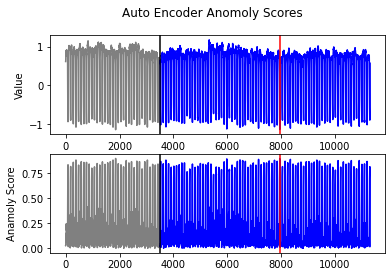

In [ ]:
# Plot results
plot_results(total, test_outlier_scores_autoenc, threshold, anamoly_pos_autoenc, "Auto Encoder Anomoly Scores", file_to_load)

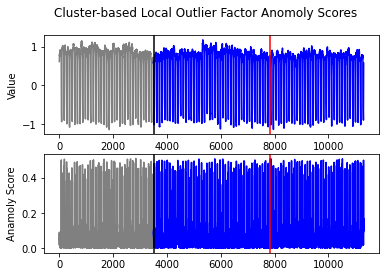

In [ ]:
# Plot results
plot_results(total, test_outlier_scores_CBLOF, threshold, anamoly_pos_CBLOF, "Cluster-based Local Outlier Factor Anomoly Scores", file_to_load)

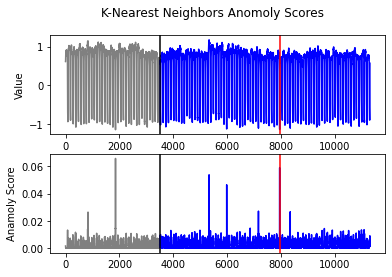

In [ ]:
# Plot results
plot_results(total, test_outlier_scores_KNN, threshold, anamoly_pos_KNN, "K-Nearest Neighbors Anomoly Scores", file_to_load)

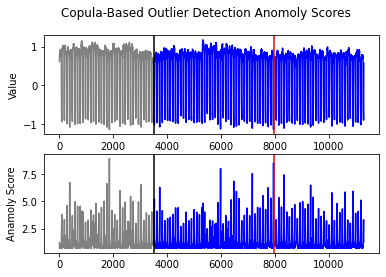

In [ ]:
# Plot
plot_results(total, test_outlier_scores_COPOD, threshold, anamoly_pos_COPOD, "Copula-Based Outlier Detection Anomoly Scores", file_to_load)